<a href="https://colab.research.google.com/github/Laplo/tp_machine_learning/blob/master/TP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Quelle est la population ayant le plus de risques de contracter le Covid-19 ?**

## **Import des librairies**

In [0]:
import pandas as pd
import numpy as np
import os

from IPython.display import Image

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import des données**

In [41]:
train = pd.read_csv('drive/My Drive/Colab Notebooks/Data/diagnosis-of-covid-19-and-its-clinical-spectrum.csv')
train.drop(["myeloblasts","urine_urobilinogen"],axis=1,inplace=True)
train.drop(["patient_addmited_to_regular_ward_1_yes_0_no","patient_addmited_to_semi_intensive_unit_1_yes_0_no","patient_addmited_to_intensive_care_unit_1_yes_0_no"],axis=1, inplace=True)
train.sample(10)

,patient_id,patient_age_quantile,sars_cov_2_exam_result,hematocrit,hemoglobin,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,basophils,mean_corpuscular_hemoglobin_mch,eosinophils,mean_corpuscular_volume_mcv,monocytes,red_blood_cell_distribution_width_rdw,serum_glucose,respiratory_syncytial_virus,influenza_a,influenza_b,parainfluenza_1,coronavirusnl63,rhinovirus_enterovirus,mycoplasma_pneumoniae,coronavirus_hku1,parainfluenza_3,chlamydophila_pneumoniae,adenovirus,parainfluenza_4,coronavirus229e,coronavirusoc43,inf_a_h1n1_2009,bordetella_pertussis,metapneumovirus,parainfluenza_2,neutrophils,urea,proteina_c_reativa_mg_dl,creatinine,...,myelocytes,urine_esterase,urine_aspect,urine_ph,urine_hemoglobin,urine_bile_pigments,urine_ketone_bodies,urine_nitrite,urine_density,urine_protein,urine_sugar,urine_leukocytes,urine_crystals,urine_red_blood_cells,urine_hyaline_cylinders,urine_granular_cylinders,urine_yeasts,urine_color,partial_thromboplastin_time_ptt,relationship_patient_normal,international_normalized_ratio_inr,lactic_dehydrogenase,prothrombin_time_pt_activity,vitamin_b12,creatine_phosphokinase_cpk,ferritin,arterial_lactic_acid,lipase_dosage,d_dimer,albumin,hb_saturation_arterial_blood_gases,pco2_arterial_blood_gas_analysis,base_excess_arterial_blood_gas_analysis,ph_arterial_blood_gas_analysis,total_co2_arterial_blood_gas_analysis,hco3_arterial_blood_gas_analysis,po2_arterial_blood_gas_analysis,arteiral_fio2,phosphor,cto2_arterial_blood_gas_analysis
5528,a9d5951f16cb5d2,4,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3113,a21a99365d01a34,18,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994,e16efc32839655a,19,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4528,6345053242dd4e8,10,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2559,6107a20d5e7f583,17,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5467,eaf4587b31b9fd7,18,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5365,563bbc1b477e202,7,negative,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

# Création des données de test

In [42]:
test = pd.read_csv('drive/My Drive/Colab Notebooks/Data/diagnosis-of-covid-19-and-its-clinical-spectrum.csv')
test.drop(["myeloblasts","urine_urobilinogen"],axis=1,inplace=True)
test.drop(["sars_cov_2_exam_result","patient_addmited_to_regular_ward_1_yes_0_no","patient_addmited_to_semi_intensive_unit_1_yes_0_no","patient_addmited_to_intensive_care_unit_1_yes_0_no"], axis=1, inplace=True)
test.sample(10)

,patient_id,patient_age_quantile,hematocrit,hemoglobin,platelets,mean_platelet_volume,red_blood_cells,lymphocytes,mean_corpuscular_hemoglobin_concentration_mchc,leukocytes,basophils,mean_corpuscular_hemoglobin_mch,eosinophils,mean_corpuscular_volume_mcv,monocytes,red_blood_cell_distribution_width_rdw,serum_glucose,respiratory_syncytial_virus,influenza_a,influenza_b,parainfluenza_1,coronavirusnl63,rhinovirus_enterovirus,mycoplasma_pneumoniae,coronavirus_hku1,parainfluenza_3,chlamydophila_pneumoniae,adenovirus,parainfluenza_4,coronavirus229e,coronavirusoc43,inf_a_h1n1_2009,bordetella_pertussis,metapneumovirus,parainfluenza_2,neutrophils,urea,proteina_c_reativa_mg_dl,creatinine,potassium,...,myelocytes,urine_esterase,urine_aspect,urine_ph,urine_hemoglobin,urine_bile_pigments,urine_ketone_bodies,urine_nitrite,urine_density,urine_protein,urine_sugar,urine_leukocytes,urine_crystals,urine_red_blood_cells,urine_hyaline_cylinders,urine_granular_cylinders,urine_yeasts,urine_color,partial_thromboplastin_time_ptt,relationship_patient_normal,international_normalized_ratio_inr,lactic_dehydrogenase,prothrombin_time_pt_activity,vitamin_b12,creatine_phosphokinase_cpk,ferritin,arterial_lactic_acid,lipase_dosage,d_dimer,albumin,hb_saturation_arterial_blood_gases,pco2_arterial_blood_gas_analysis,base_excess_arterial_blood_gas_analysis,ph_arterial_blood_gas_analysis,total_co2_arterial_blood_gas_analysis,hco3_arterial_blood_gas_analysis,po2_arterial_blood_gas_analysis,arteiral_fio2,phosphor,cto2_arterial_blood_gas_analysis
5533,67c110fa326d263,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1442,7be14fb4f79c9d8,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2750,4aaecb5b6860023,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2857,03f498f194c3922,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3217,cbd8cd9af3b75c0,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2661,ef82b763ac24569,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4562,44ceecd0b4b92f5,15,-0.724805,-1.212804,0.650835,-0.55029,-0.832405,-1.694489,-2.245306,0.634481,-1.140144,-0.710443,-0.414114,0.366488,-1.270772,2.205534,0.798171,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,not_detected,NaN,-0.141742,-0.273077,-0.632489,-1.294433

# Préparation des données de training

# Création des catégories 

In [0]:
train["urine_crystals"] = train["urine_crystals"].map(
    {    "Ausentes": 0,
         "Urato Amorfo --+": 1,
         "Oxalato de Cálcio +++": 2,
         "Oxalato de Cálcio -++": 3,
         "Urato Amorfo +++": 4,
    }
) 

train["urine_color"] = train["urine_color"].map(
    {    "light_yellow": 0,
         "yellow": 1,
         "orange": 2,
         "citrus_yellow": 3,
    }
) 

train["urine_aspect"] = train["urine_aspect"].map(
    {    "clear": 0,
         "cloudy": 1,
         "altered_coloring": 2,
         "lightly_cloudy": 3,
    }
) 

In [0]:
train = train.replace(to_replace="detected",value=1)
train = train.replace(to_replace="not_detected",value=0)
train = train.replace(to_replace="not_done",value=-299)
train = train.replace(to_replace="absent",value=0)
train = train.replace(to_replace="present",value=1)
train = train.replace(to_replace="Não Realizado",value=-299)
train = train.replace(to_replace="negative",value=0)
train = train.replace(to_replace="<1000",value=0)
train = train.replace(to_replace="positive",value=1)

train = train.replace(to_replace=np.NaN,value=-299)

In [45]:
mid = train['sars_cov_2_exam_result']
train.drop(labels=['sars_cov_2_exam_result'], axis=1, inplace = True)
train.insert(1, 'sars_cov_2_exam_result', mid)

X_alltrain = pd.DataFrame(train.iloc[:, 2:]).to_numpy()
print("Type of X_alltrain :", type(X_alltrain))
X_alltrain[:10]

Type of X_alltrain : <class 'numpy.ndarray'>


array([[13, -299.0, -299.0, ..., -299.0, -299.0, -299.0],
       [17, 0.236515447497368, -0.0223402678966522, ..., -299.0, -299.0,
        -299.0],
       [8, -299.0, -299.0, ..., -299.0, -299.0, -299.0],
       ...,
       [16, -299.0, -299.0, ..., -299.0, -299.0, -299.0],
       [1, -1.57168221473694, -0.774212002754211, ..., -299.0,
        0.730392932891846, -299.0],
       [17, -299.0, -299.0, ..., -299.0, -299.0, -299.0]], dtype=object)

# Chargement des labels

In [46]:
y_alltrain = pd.DataFrame(train[["sars_cov_2_exam_result"]]).to_numpy()
y_alltrain[:10]

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

# Affichage nom des features

# fonction utiles

In [0]:
def generer_resultats(clf,df_test=test):
    """
    Fonctions permettant de générer le fichier d'envoi à Kaggle.
    On passe un classifier sur lequel on refait le training avec toutes les données de training
    
    Parameters
    ----------
    Classifiers : Classifier utilisé pour la prédiction
    data : Données à calculer. par défaut, les valeurs du dataset "test"
    idx : Index des passagers testés. Stockés dans finalfile_index lors de la lecture des données
    """    
    data = df_test.iloc[:,1:].values
    idx = df_test.patient_id
    print(clf.get_params())
    clf.fit(X_alltrain, y_alltrain)
    prediction=clf.predict(data)
    results=pd.DataFrame(prediction.astype(int), index = df_test.patient_id, columns=['sars_cov_2_exam_result'])
    results.to_csv('resultats%s.csv'%clf.__class__.__name__)
  


def plot_decision_boundary(clf,X,y, axes=[-0, 30, -5, 5], axis_name=['x1','x2'],alpha=0.5, contour=True):
    """
    Fonction pour l'affichage 2 D des résultats   
    
    Parameters
    ----------
    clf : Classifier à afficher
    X : features de Données a afficher
    y : labels de Données a afficher  
    axes : : Tailles des axes (valeur min/max)
    axis_name : Nom des axes sur le graphique
    alpha : Transparence des points
    contour : Afichage du contour
    """     
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bo",label="Negatif", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "ys", label="Positif",alpha=alpha)
    plt.axis(axes)
    plt.xlabel(axis_name[0], fontsize=18)
    plt.ylabel(axis_name[1]+ "  ",fontsize=18, rotation=0)    
    plt.legend(loc="lower right", fontsize=14)

# Création arbre de décision

In [0]:
pd.options.display.max_rows=150

In [49]:
train["hematocrit"].unique()

array([-2.99000000e+02,  2.36515447e-01, -1.57168221e+00, -7.47693062e-01,
        9.91838217e-01,  1.90738127e-01,  1.01472640e+00,  7.40064204e-01,
       -6.79027498e-01,  8.08729768e-01, -1.06813163e-01,  1.42672145e+00,
        7.17175126e-01,  9.46060896e-01,  6.25621319e-01, -1.52590483e-01,
        6.71397805e-01, -2.21256033e-01, -8.16359460e-01, -6.56139314e-01,
       -5.18807352e-01,  4.42512095e-01, -5.41696429e-01, -4.50141758e-01,
        1.22072399e+00,  2.82292753e-01,  6.94286883e-01, -8.62135947e-01,
        5.79843998e-01,  3.05179283e-02, -3.81476171e-02, -1.29701912e+00,
       -1.98367643e+00,  1.03761554e+00,  2.09048939e+00, -4.04364437e-01,
        7.62952447e-01,  1.49538696e+00, -7.01916635e-01, -1.36568463e+00,
       -1.06813335e+00,  1.10628104e+00, -3.81476223e-01,  1.17494667e+00,
        3.05180997e-01, -7.93470383e-01,  1.38094413e+00,  1.72427273e+00,
        3.96735638e-01,  1.63271809e+00,  1.08339286e+00,  4.65401143e-01,
        1.24361217e+00,  

# Séparation des features et labels

In [50]:
X_train, X_dev, y_train, y_dev = train_test_split(X_alltrain, y_alltrain, random_state=42)
print('Rows & cols of X_train', X_train.shape)
print('Rows & cols of y_train', y_train.shape)
print('Rows & cols of X_dev', X_dev.shape)
print('Rows & cols of y_dev', y_dev.shape)

Rows & cols of X_train (4233, 104)
Rows & cols of y_train (4233, 1)
Rows & cols of X_dev (1411, 104)
Rows & cols of y_dev (1411, 1)


In [0]:
feature_names = train.columns[2:].values.tolist()

In [52]:
train.dtypes

patient_id                                         object
sars_cov_2_exam_result                              int64
patient_age_quantile                                int64
hematocrit                                        float64
hemoglobin                                        float64
platelets                                         float64
mean_platelet_volume                              float64
red_blood_cells                                   float64
lymphocytes                                       float64
mean_corpuscular_hemoglobin_concentration_mchc    float64
leukocytes                                        float64
basophils                                         float64
mean_corpuscular_hemoglobin_mch                   float64
eosinophils                                       float64
mean_corpuscular_volume_mcv                       float64
monocytes                                         float64
red_blood_cell_distribution_width_rdw             float64
serum_glucose 

In [53]:
train.isin([np.NaN]).any()

patient_id                                        False
sars_cov_2_exam_result                            False
patient_age_quantile                              False
hematocrit                                        False
hemoglobin                                        False
platelets                                         False
mean_platelet_volume                              False
red_blood_cells                                   False
lymphocytes                                       False
mean_corpuscular_hemoglobin_concentration_mchc    False
leukocytes                                        False
basophils                                         False
mean_corpuscular_hemoglobin_mch                   False
eosinophils                                       False
mean_corpuscular_volume_mcv                       False
monocytes                                         False
red_blood_cell_distribution_width_rdw             False
serum_glucose                                   

In [56]:
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train.ravel())

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [57]:
for name, score in zip(feature_names, rnd_clf.feature_importances_):
    print('%s: %i%%' %(name, int(score*100)))
best = {}
best['score'] = 0
for x in range(1, 20):
  rnd_clf = RandomForestClassifier(n_estimators=(100 + ((100*x)%1000)), n_jobs=-1, random_state=42, max_depth=x, max_features=(1 + x%6))
  rnd_clf.fit(X_train, y_train.ravel())
  y_pred = rnd_clf.predict(X_dev)
  ac_score = accuracy_score(y_dev, y_pred)
  if ac_score >= best['score']:
    best['depth'] = x
    best['score'] = ac_score
    best['clf'] = rnd_clf
    best['features'] = (1 + x%6)
    best['estimators'] = (100 + ((100*x)%500))
  print('Score is', ac_score, 'as depth', x, 'with', (1 + x%6), 'features and estimators', (100 + ((100*x)%1000)))
print('Best score was', best['score'], 'as depth', best['depth'], 'with', best['features'], 'features and estimators', best['estimators'])

patient_age_quantile: 27%
hematocrit: 2%
hemoglobin: 1%
platelets: 2%
mean_platelet_volume: 1%
red_blood_cells: 2%
lymphocytes: 1%
mean_corpuscular_hemoglobin_concentration_mchc: 1%
leukocytes: 4%
basophils: 1%
mean_corpuscular_hemoglobin_mch: 1%
eosinophils: 1%
mean_corpuscular_volume_mcv: 1%
monocytes: 4%
red_blood_cell_distribution_width_rdw: 1%
serum_glucose: 0%
respiratory_syncytial_virus: 0%
influenza_a: 0%
influenza_b: 0%
parainfluenza_1: 0%
coronavirusnl63: 0%
rhinovirus_enterovirus: 1%
mycoplasma_pneumoniae: 0%
coronavirus_hku1: 0%
parainfluenza_3: 0%
chlamydophila_pneumoniae: 0%
adenovirus: 0%
parainfluenza_4: 0%
coronavirus229e: 0%
coronavirusoc43: 0%
inf_a_h1n1_2009: 0%
bordetella_pertussis: 0%
metapneumovirus: 0%
parainfluenza_2: 0%
neutrophils: 1%
urea: 1%
proteina_c_reativa_mg_dl: 2%
creatinine: 1%
potassium: 0%
sodium: 0%
influenza_b_rapid_test: 1%
influenza_a_rapid_test: 1%
alanine_transaminase: 0%
aspartate_transaminase: 1%
gamma_glutamyltransferase: 1%
total_bilirubi

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: UserWarning: No contour levels were found within the data range.


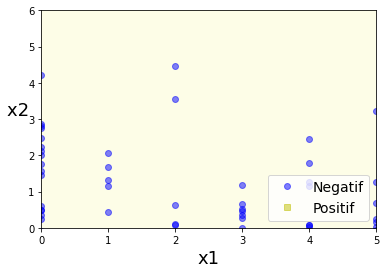

In [60]:
X_alltraintwo = pd.DataFrame(train[["patient_age_quantile", "leukocytes"]]).to_numpy()
y_alltraintwo = pd.DataFrame(train[["sars_cov_2_exam_result"]]).to_numpy()
X_traintwo, X_devtwo, y_traintwo, y_devtwo = train_test_split(X_alltraintwo, y_alltraintwo.ravel(), random_state=42)

rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42, max_depth=4)
rnd_clf.fit(X_traintwo, y_traintwo)
plot_decision_boundary(rnd_clf, X_traintwo, y_traintwo.ravel(), axes=[0, 5, 0, 6])